# 🧪 MULTI-SEED STABILITY TEST
## Kiểm tra độ ổn định của HGT Knowledge Graph Model

**Mục tiêu:** Chạy model với 10 seeds khác nhau để đánh giá:
- Mean AUC
- Standard Deviation
- Confidence Interval
- So sánh với ECFP4 baseline

In [1]:
# =============================================================================
# 1. IMPORT & CONFIGURATION
# =============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem.Scaffolds import MurckoScaffold
from graphdatascience import GraphDataScience
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
from collections import defaultdict
import warnings
import random
from scipy import stats

import torch
import torch.nn as nn
from torch_geometric.nn import HGTConv, Linear
from torch_geometric.data import HeteroData
import torch.nn.functional as F

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

NEO4J_URI = "bolt://localhost:7687"
NEO4J_AUTH = ("neo4j", "12345678")
CSV_PATH = "Data/data_end.csv"

TEST_SEEDS = [42, 123, 456, 789, 101112, 131415, 161718, 192021, 222324, 252627]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🖥️ Device: {device}")
print(f"🔢 Testing with {len(TEST_SEEDS)} different seeds")
print(f"📦 Using HGT with SUPERVISED training (NO DATA LEAKAGE)")

🖥️ Device: cpu
🔢 Testing with 10 different seeds
📦 Using HGT with SUPERVISED training (NO DATA LEAKAGE)


In [2]:
# =============================================================================
# 2. UTILITY FUNCTIONS
# =============================================================================

def canonicalize_smiles(smi):
    try:
        mol = Chem.MolFromSmiles(smi)
        if mol:
            return Chem.MolToSmiles(mol, canonical=True, isomericSmiles=False)
        return None
    except:
        return None

def scaffold_split_balanced(df, smiles_col='SMILES', test_size=0.2, seed=42):
    """Scaffold split với seed cố định cho reproducibility"""
    np.random.seed(seed)
    scaffold_dict = defaultdict(list)
    
    for idx, smi in enumerate(df[smiles_col]):
        mol = Chem.MolFromSmiles(smi)
        try:
            scaf = MurckoScaffold.MurckoScaffoldSmiles(mol=mol, includeChirality=False) if mol else "Generic"
        except:
            scaf = "Generic"
        scaffold_dict[scaf].append(idx)
    
    groups = sorted(scaffold_dict.values(), key=len, reverse=True)
    train_inds, test_inds = [], []
    target_test_size = len(df) * test_size
    
    for group in groups:
        if len(test_inds) + len(group) <= target_test_size + 50:
            test_inds.extend(group)
        else:
            train_inds.extend(group)
    
    return df.iloc[train_inds].copy(), df.iloc[test_inds].copy()

def get_ecfp4(smiles_list):
    return np.array([np.array(AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(s), 2, nBits=1024)) 
                     for s in smiles_list])

In [3]:
# =============================================================================
# 3. HGT MODEL WITH SELF-SUPERVISED LEARNING (NO LABEL LEAKAGE)
# =============================================================================
# [FIX DATA LEAK] - Changed from supervised to self-supervised training

class HGT_SelfSupervised(torch.nn.Module):
    """
    HGT with self-supervised pretraining (link prediction)
    - NO activity labels used during pretraining
    - Learn representations from graph topology only
    """
    def __init__(self, hidden_channels, num_heads, num_layers, metadata):
        super().__init__()
        
        # Input projection for each node type
        self.lin_dict = torch.nn.ModuleDict()
        for node_type in metadata[0]:
            self.lin_dict[node_type] = Linear(-1, hidden_channels)
        
        # HGT Convolution layers
        self.convs = torch.nn.ModuleList()
        for _ in range(num_layers):
            conv = HGTConv(hidden_channels, hidden_channels, metadata, num_heads)
            self.convs.append(conv)
    
    def forward(self, x_dict, edge_index_dict):
        # Input projection
        x_dict = {
            node_type: self.lin_dict[node_type](x).relu_()
            for node_type, x in x_dict.items()
        }
        
        # HGT layers
        for conv in self.convs:
            x_dict = conv(x_dict, edge_index_dict)
            x_dict = {key: x.relu() for key, x in x_dict.items()}
        
        return x_dict

def link_prediction_loss(embeddings, edge_index, neg_edge_index):
    """
    Self-supervised link prediction loss
    - Predict existence of edges from embeddings
    - NO activity labels involved
    """
    # Positive edges (exist in graph)
    src_emb = embeddings[edge_index[0]]
    dst_emb = embeddings[edge_index[1]]
    pos_score = (src_emb * dst_emb).sum(dim=1)
    pos_loss = -torch.log(torch.sigmoid(pos_score) + 1e-15).mean()
    
    # Negative edges (sampled randomly)
    src_neg_emb = embeddings[neg_edge_index[0]]
    dst_neg_emb = embeddings[neg_edge_index[1]]
    neg_score = (src_neg_emb * dst_neg_emb).sum(dim=1)
    neg_loss = -torch.log(1 - torch.sigmoid(neg_score) + 1e-15).mean()
    
    return pos_loss + neg_loss

def sample_negative_edges(num_nodes, num_neg_samples):
    """Sample random negative edges for link prediction"""
    neg_edges = torch.randint(0, num_nodes, (2, num_neg_samples))
    return neg_edges

In [4]:
# =============================================================================
# 4. BUILD TRULY INDEPENDENT GRAPHS (STRICT SEPARATION)
# =============================================================================
# [FIX DATA LEAK] - Complete rewrite to ensure zero overlap

def build_independent_graphs(gds, train_mol_ids, test_mol_ids, seed):
    """
    Build COMPLETELY INDEPENDENT train and test graphs
    
    CRITICAL CHANGES:
    1. Train graph contains ONLY train molecules + their connections
    2. Test graph contains ONLY test molecules + their connections
    3. Shared entities (Scaffold, Target, etc.) use SAME features BUT different local indices
    4. NO topology leakage - graphs are disjoint
    """
    # ==================== SANITY CHECK ====================
    # [FIX DATA LEAK] - Verify no overlap
    overlap = set(train_mol_ids) & set(test_mol_ids)
    assert len(overlap) == 0, f"❌ LEAKAGE DETECTED: {len(overlap)} overlapping molecules!"
    
    # ==================== LOAD ALL ENTITIES ====================
    all_molecules = gds.run_cypher("""
        MATCH (n:Molecule) WHERE n.is_virtual = false
        RETURN id(n) as node_id, n.smiles as smiles
    """)
    
    scaffolds = gds.run_cypher("MATCH (n:Scaffold) RETURN id(n) as node_id, n.smiles as smiles")
    targets = gds.run_cypher("MATCH (n:Target) RETURN id(n) as node_id, n.name as name")
    functional_groups = gds.run_cypher("MATCH (n:FunctionalGroup) RETURN id(n) as node_id, n.name as name")
    warheads = gds.run_cypher("MATCH (n:Warhead) RETURN id(n) as node_id, n.name as name")
    moas = gds.run_cypher("MATCH (n:MoA) RETURN id(n) as node_id, n.name as name")
    
    # ==================== LOAD ALL EDGES ====================
    # NOTE: Prevent label leakage. In BuildKG.py, POTENT_AGAINST is created ONLY for Active molecules,
    # so including it would leak the target label via graph topology.
    all_edges = gds.run_cypher("""
        MATCH (m)-[r]->(n)
        WHERE ((m:Molecule AND m.is_virtual = false) OR (n:Molecule AND n.is_virtual = false))
          AND type(r) IN ['HAS_SCAFFOLD','HAS_FUNCTIONAL_GROUP','CONTAINS_WARHEAD','ACTS_VIA','TESTED_AGAINST']
        RETURN id(m) as src, type(r) as rel_type, id(n) as dst, 
               labels(m)[0] as src_type, labels(n)[0] as dst_type
    """)
    
    # ==================== SPLIT MOLECULES ====================
    train_molecules = all_molecules[all_molecules['node_id'].isin(train_mol_ids)].reset_index(drop=True)
    test_molecules = all_molecules[all_molecules['node_id'].isin(test_mol_ids)].reset_index(drop=True)
    
    print(f"   ✅ Train: {len(train_molecules)} mols, Test: {len(test_molecules)} mols")
    
    # ==================== INITIALIZE SHARED FEATURES ====================
    # [FIX DATA LEAK] - Features are shared BUT indices are separate
    torch.manual_seed(seed)
    embed_dim = 128
    
    # Global feature matrices (SAME for both graphs)
    global_scaffold_feats = torch.randn(len(scaffolds), embed_dim)
    global_target_feats = torch.randn(len(targets), embed_dim)
    global_fg_feats = torch.randn(len(functional_groups), embed_dim)
    global_wh_feats = torch.randn(len(warheads), embed_dim)
    global_moa_feats = torch.randn(len(moas), embed_dim)
    
    # Global ID to feature index mapping
    global_scaf_map = {row['node_id']: i for i, row in scaffolds.iterrows()}
    global_targ_map = {row['node_id']: i for i, row in targets.iterrows()}
    global_fg_map = {row['node_id']: i for i, row in functional_groups.iterrows()}
    global_wh_map = {row['node_id']: i for i, row in warheads.iterrows()}
    global_moa_map = {row['node_id']: i for i, row in moas.iterrows()}
    
    # ==================== BUILD TRAIN GRAPH ====================
    train_data = HeteroData()
    
    # LOCAL indexing for train molecules
    train_mol_local_map = {row['node_id']: i for i, row in train_molecules.iterrows()}
    
    # Collect entities actually connected to train molecules
    train_connected_entities = {
        'Scaffold': set(), 'Target': set(), 'FunctionalGroup': set(),
        'Warhead': set(), 'MoA': set()
    }
    
    # Filter edges to train graph only
    train_edges = []
    for _, row in all_edges.iterrows():
        src_type, dst_type = row['src_type'], row['dst_type']
        src_id, dst_id = row['src'], row['dst']
        
        # [FIX DATA LEAK] - CRITICAL: Skip ANY edge touching test molecules
        if src_type == 'Molecule' and src_id not in train_mol_local_map:
            continue
        if dst_type == 'Molecule' and dst_id not in train_mol_local_map:
            continue
        
        # Track connected entities
        if src_type != 'Molecule':
            train_connected_entities[src_type].add(src_id)
        if dst_type != 'Molecule':
            train_connected_entities[dst_type].add(dst_id)
        
        train_edges.append(row)
    
    # Create LOCAL mappings for shared entities in train graph
    train_scaf_local = {gid: i for i, gid in enumerate(sorted(train_connected_entities['Scaffold']))}
    train_targ_local = {gid: i for i, gid in enumerate(sorted(train_connected_entities['Target']))}
    train_fg_local = {gid: i for i, gid in enumerate(sorted(train_connected_entities['FunctionalGroup']))}
    train_wh_local = {gid: i for i, gid in enumerate(sorted(train_connected_entities['Warhead']))}
    train_moa_local = {gid: i for i, gid in enumerate(sorted(train_connected_entities['MoA']))}
    
    # Set features (select from global features)
    train_data['Molecule'].x = torch.randn(len(train_molecules), embed_dim)
    train_data['Scaffold'].x = global_scaffold_feats[[global_scaf_map[gid] for gid in sorted(train_connected_entities['Scaffold'])]]
    train_data['Target'].x = global_target_feats[[global_targ_map[gid] for gid in sorted(train_connected_entities['Target'])]]
    train_data['FunctionalGroup'].x = global_fg_feats[[global_fg_map[gid] for gid in sorted(train_connected_entities['FunctionalGroup'])]]
    train_data['Warhead'].x = global_wh_feats[[global_wh_map[gid] for gid in sorted(train_connected_entities['Warhead'])]]
    train_data['MoA'].x = global_moa_feats[[global_moa_map[gid] for gid in sorted(train_connected_entities['MoA'])]]
    
    # Build train edges with local indices
    train_edge_dict = defaultdict(lambda: [[], []])
    train_local_maps = {
        'Molecule': train_mol_local_map,
        'Scaffold': train_scaf_local,
        'Target': train_targ_local,
        'FunctionalGroup': train_fg_local,
        'Warhead': train_wh_local,
        'MoA': train_moa_local
    }
    
    for row in train_edges:
        src_type, dst_type = row['src_type'], row['dst_type']
        src_id, dst_id = row['src'], row['dst']
        
        if src_id not in train_local_maps[src_type] or dst_id not in train_local_maps[dst_type]:
            continue
        
        src_idx = train_local_maps[src_type][src_id]
        dst_idx = train_local_maps[dst_type][dst_id]
        
        key = (src_type, row['rel_type'], dst_type)
        train_edge_dict[key][0].append(src_idx)
        train_edge_dict[key][1].append(dst_idx)
        
        # Reverse edges
        rev_key = (dst_type, f"rev_{row['rel_type']}", src_type)
        train_edge_dict[rev_key][0].append(dst_idx)
        train_edge_dict[rev_key][1].append(src_idx)
    
    for key, (srcs, dsts) in train_edge_dict.items():
        train_data[key].edge_index = torch.tensor([srcs, dsts], dtype=torch.long)
    
    # ==================== BUILD TEST GRAPH (SAME PROCESS) ====================
    test_data = HeteroData()
    
    test_mol_local_map = {row['node_id']: i for i, row in test_molecules.iterrows()}
    
    test_connected_entities = {
        'Scaffold': set(), 'Target': set(), 'FunctionalGroup': set(),
        'Warhead': set(), 'MoA': set()
    }
    
    test_edges = []
    for _, row in all_edges.iterrows():
        src_type, dst_type = row['src_type'], row['dst_type']
        src_id, dst_id = row['src'], row['dst']
        
        # [FIX DATA LEAK] - CRITICAL: Skip ANY edge touching train molecules
        if src_type == 'Molecule' and src_id not in test_mol_local_map:
            continue
        if dst_type == 'Molecule' and dst_id not in test_mol_local_map:
            continue
        
        if src_type != 'Molecule':
            test_connected_entities[src_type].add(src_id)
        if dst_type != 'Molecule':
            test_connected_entities[dst_type].add(dst_id)
        
        test_edges.append(row)
    
    test_scaf_local = {gid: i for i, gid in enumerate(sorted(test_connected_entities['Scaffold']))}
    test_targ_local = {gid: i for i, gid in enumerate(sorted(test_connected_entities['Target']))}
    test_fg_local = {gid: i for i, gid in enumerate(sorted(test_connected_entities['FunctionalGroup']))}
    test_wh_local = {gid: i for i, gid in enumerate(sorted(test_connected_entities['Warhead']))}
    test_moa_local = {gid: i for i, gid in enumerate(sorted(test_connected_entities['MoA']))}
    
    test_data['Molecule'].x = torch.randn(len(test_molecules), embed_dim)
    test_data['Scaffold'].x = global_scaffold_feats[[global_scaf_map[gid] for gid in sorted(test_connected_entities['Scaffold'])]]
    test_data['Target'].x = global_target_feats[[global_targ_map[gid] for gid in sorted(test_connected_entities['Target'])]]
    test_data['FunctionalGroup'].x = global_fg_feats[[global_fg_map[gid] for gid in sorted(test_connected_entities['FunctionalGroup'])]]
    test_data['Warhead'].x = global_wh_feats[[global_wh_map[gid] for gid in sorted(test_connected_entities['Warhead'])]]
    test_data['MoA'].x = global_moa_feats[[global_moa_map[gid] for gid in sorted(test_connected_entities['MoA'])]]
    
    test_edge_dict = defaultdict(lambda: [[], []])
    test_local_maps = {
        'Molecule': test_mol_local_map,
        'Scaffold': test_scaf_local,
        'Target': test_targ_local,
        'FunctionalGroup': test_fg_local,
        'Warhead': test_wh_local,
        'MoA': test_moa_local
    }
    
    for row in test_edges:
        src_type, dst_type = row['src_type'], row['dst_type']
        src_id, dst_id = row['src'], row['dst']
        
        if src_id not in test_local_maps[src_type] or dst_id not in test_local_maps[dst_type]:
            continue
        
        src_idx = test_local_maps[src_type][src_id]
        dst_idx = test_local_maps[dst_type][dst_id]
        
        key = (src_type, row['rel_type'], dst_type)
        test_edge_dict[key][0].append(src_idx)
        test_edge_dict[key][1].append(dst_idx)
        
        rev_key = (dst_type, f"rev_{row['rel_type']}", src_type)
        test_edge_dict[rev_key][0].append(dst_idx)
        test_edge_dict[rev_key][1].append(src_idx)
    
    for key, (srcs, dsts) in test_edge_dict.items():
        test_data[key].edge_index = torch.tensor([srcs, dsts], dtype=torch.long)
    
    print(f"   ✅ Train edges: {sum(len(e[0]) for e in train_edge_dict.values())}, Test edges: {sum(len(e[0]) for e in test_edge_dict.values())}")
    
    return train_data, test_data, train_mol_local_map, test_mol_local_map, train_molecules, test_molecules

In [5]:
# =============================================================================
# 5. SINGLE EXPERIMENT (SELF-SUPERVISED + FROZEN ENCODER)
# =============================================================================
# [FIX DATA LEAK] - Complete pipeline rewrite

def run_single_experiment(seed, gds, df, verbose=False):
    """
    CORRECTED PIPELINE:
    1. Scaffold split FIRST (before any graph ops)
    2. Build independent train/test graphs
    3. Self-supervised pretraining on TRAIN graph only (link prediction)
    4. FREEZE encoder → extract embeddings from BOTH graphs
    5. Train classifier ONLY on train embeddings
    6. Evaluate on test embeddings
    """
    if verbose:
        print(f"\n{'='*60}")
        print(f"🎲 Seed = {seed}")
        print(f"{'='*60}")
    
    # Set all seeds
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
    
    # ==================== STEP 1: SCAFFOLD SPLIT ====================
    # [FIX DATA LEAK] - This happens FIRST, before ANY graph construction
    train_df, test_df = scaffold_split_balanced(df, seed=seed)
    
    y_train = train_df['Label_Num'].values
    y_test = test_df['Label_Num'].values
    
    # Map to Neo4j IDs
    all_molecules = gds.run_cypher("""
        MATCH (n:Molecule) WHERE n.is_virtual = false
        RETURN id(n) as node_id, n.smiles as smiles
    """)
    all_molecules['SMILES_Key'] = all_molecules['smiles'].apply(canonicalize_smiles)
    
    train_df_id = pd.merge(train_df, all_molecules[['SMILES_Key', 'node_id']], on='SMILES_Key', how='inner')
    test_df_id = pd.merge(test_df, all_molecules[['SMILES_Key', 'node_id']], on='SMILES_Key', how='inner')
    
    train_mol_ids = set(train_df_id['node_id'].values)
    test_mol_ids = set(test_df_id['node_id'].values)
    
    if verbose:
        print(f"  🔀 Split: Train={len(train_mol_ids)}, Test={len(test_mol_ids)}")
    
    # ==================== STEP 2: BUILD INDEPENDENT GRAPHS ====================
    train_data, test_data, train_mol_map, test_mol_map, train_molecules, test_molecules = \
        build_independent_graphs(gds, train_mol_ids, test_mol_ids, seed)
    
    train_data = train_data.to(device)
    test_data = test_data.to(device)
    
    # ==================== STEP 3: SELF-SUPERVISED PRETRAINING ====================
    # [FIX DATA LEAK] - NO activity labels used here!
    model = HGT_SelfSupervised(
        hidden_channels=128,
        num_heads=4,
        num_layers=2,
        metadata=train_data.metadata()
    ).to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
    
    # Select a relation for link prediction (e.g., Molecule-HAS_SCAFFOLD-Scaffold)
    link_pred_edge_type = None
    for edge_type in train_data.edge_types:
        if edge_type[0] == 'Molecule' and edge_type[2] == 'Scaffold':
            link_pred_edge_type = edge_type
            break
    
    if link_pred_edge_type is None:
        # Fallback to any Molecule edge
        for edge_type in train_data.edge_types:
            if edge_type[0] == 'Molecule':
                link_pred_edge_type = edge_type
                break
    
    model.train()
    for epoch in range(50):
        optimizer.zero_grad()
        
        # Forward pass
        embeddings_dict = model(train_data.x_dict, train_data.edge_index_dict)
        mol_embeddings = embeddings_dict['Molecule']
        
        # Sample negative edges for link prediction
        edge_index = train_data[link_pred_edge_type].edge_index
        num_nodes = train_data['Molecule'].x.size(0)
        neg_edge_index = sample_negative_edges(num_nodes, edge_index.size(1)).to(device)
        
        # Link prediction loss (self-supervised)
        loss = link_prediction_loss(mol_embeddings, edge_index, neg_edge_index)
        
        loss.backward()
        optimizer.step()
        
        if verbose and (epoch + 1) % 10 == 0:
            print(f"    Epoch {epoch+1}/50 | Self-Supervised Loss: {loss.item():.4f}")
    
    # ==================== STEP 4: FREEZE & EXTRACT EMBEDDINGS ====================
    # [FIX DATA LEAK] - Model is now frozen, NO further training
    model.eval()
    with torch.no_grad():
        train_emb_dict = model(train_data.x_dict, train_data.edge_index_dict)
        test_emb_dict = model(test_data.x_dict, test_data.edge_index_dict)
        
        train_mol_emb = train_emb_dict['Molecule'].cpu().numpy()
        test_mol_emb = test_emb_dict['Molecule'].cpu().numpy()
    
    # Map back to dataframes
    train_emb_df = train_molecules.copy()
    train_emb_df['embedding'] = list(train_mol_emb)
    train_emb_df['SMILES_Key'] = train_emb_df['smiles'].apply(canonicalize_smiles)
    
    test_emb_df = test_molecules.copy()
    test_emb_df['embedding'] = list(test_mol_emb)
    test_emb_df['SMILES_Key'] = test_emb_df['smiles'].apply(canonicalize_smiles)
    
    train_final = pd.merge(train_df, train_emb_df[['SMILES_Key', 'embedding']], on='SMILES_Key', how='inner')
    test_final = pd.merge(test_df, test_emb_df[['SMILES_Key', 'embedding']], on='SMILES_Key', how='inner')
    
    # ==================== STEP 5: DOWNSTREAM CLASSIFIER ====================
    # [FIX DATA LEAK] - Classifier trained ONLY on train data
    X_ecfp_train = get_ecfp4(train_final['SMILES'])
    X_ecfp_test = get_ecfp4(test_final['SMILES'])
    X_kg_train = np.stack(train_final['embedding'].values)
    X_kg_test = np.stack(test_final['embedding'].values)
    
    y_train_final = train_final['Label_Num'].values
    y_test_final = test_final['Label_Num'].values
    
    # ECFP4 baseline
    rf_ecfp = RandomForestClassifier(n_estimators=100, random_state=seed, n_jobs=-1)
    rf_ecfp.fit(X_ecfp_train, y_train_final)
    y_prob_ecfp = rf_ecfp.predict_proba(X_ecfp_test)[:, 1]
    
    # KG embeddings
    rf_kg = RandomForestClassifier(n_estimators=100, random_state=seed, n_jobs=-1)
    rf_kg.fit(X_kg_train, y_train_final)
    y_prob_kg = rf_kg.predict_proba(X_kg_test)[:, 1]
    
    # ==================== STEP 6: SANITY CHECKS ====================
    # [FIX DATA LEAK] - Permutation test
    y_permuted = np.random.permutation(y_train_final)
    rf_kg_perm = RandomForestClassifier(n_estimators=100, random_state=seed, n_jobs=-1)
    rf_kg_perm.fit(X_kg_train, y_permuted)
    y_prob_kg_perm = rf_kg_perm.predict_proba(X_kg_test)[:, 1]
    
    # Random embedding baseline
    X_random_train = np.random.randn(*X_kg_train.shape)
    X_random_test = np.random.randn(*X_kg_test.shape)
    rf_random = RandomForestClassifier(n_estimators=100, random_state=seed, n_jobs=-1)
    rf_random.fit(X_random_train, y_train_final)
    y_prob_random = rf_random.predict_proba(X_random_test)[:, 1]
    
    # ==================== COMPUTE METRICS ====================
    auc_ecfp = roc_auc_score(y_test_final, y_prob_ecfp)
    auc_kg = roc_auc_score(y_test_final, y_prob_kg)
    auc_kg_perm = roc_auc_score(y_test_final, y_prob_kg_perm)
    auc_random = roc_auc_score(y_test_final, y_prob_random)
    
    acc_ecfp = accuracy_score(y_test_final, (y_prob_ecfp > 0.5).astype(int))
    acc_kg = accuracy_score(y_test_final, (y_prob_kg > 0.5).astype(int))
    
    if verbose:
        print(f"  📊 ECFP4       -> AUC: {auc_ecfp:.4f}, ACC: {acc_ecfp:.4f}")
        print(f"  📊 HGT (SS)    -> AUC: {auc_kg:.4f}, ACC: {acc_kg:.4f}")
        print(f"  🔍 Sanity: Permuted={auc_kg_perm:.4f}, Random={auc_random:.4f}")
        print(f"  ✅ Graphs are independent (NO leakage)")
    
    return {
        'seed': seed,
        'auc_ecfp': auc_ecfp,
        'auc_kg': auc_kg,
        'acc_ecfp': acc_ecfp,
        'acc_kg': acc_kg,
        'auc_kg_permuted': auc_kg_perm,
        'auc_random': auc_random
    }

In [6]:
# =============================================================================
# 6. RUN MULTI-SEED EXPERIMENTS
# =============================================================================
# [FIX DATA LEAK] - Keep same, but now calls corrected pipeline

# Load data once
df = pd.read_csv(CSV_PATH)
df = df[df['Final_Label'] != 'Uncertain']
df['Label_Num'] = df['Final_Label'].apply(lambda x: 1 if str(x).lower() == 'active' else 0)
df['SMILES_Key'] = df['SMILES'].apply(canonicalize_smiles)
df = df.dropna(subset=['SMILES_Key']).drop_duplicates(subset=['SMILES_Key'])

gds = GraphDataScience(NEO4J_URI, auth=NEO4J_AUTH)

print("\n" + "="*80)
print("🚀 MULTI-SEED STABILITY TEST (CORRECTED - NO LEAKAGE)")
print(f"   Testing {len(TEST_SEEDS)} seeds")
print("="*80)
print("\n✅ FIXES APPLIED:")
print("   1. Scaffold split BEFORE graph construction")
print("   2. Completely independent train/test graphs")
print("   3. Self-supervised pretraining (NO label leakage)")
print("   4. FROZEN encoder for test inference")
print("   5. Sanity checks (permutation + random baseline)")
print("="*80)

# Run experiments
results = []
for i, seed in enumerate(TEST_SEEDS, 1):
    print(f"\n[{i}/{len(TEST_SEEDS)}] Seed = {seed}")
    result = run_single_experiment(seed, gds, df, verbose=True)
    results.append(result)

results_df = pd.DataFrame(results)
print("\n✅ All experiments completed!")


🚀 MULTI-SEED STABILITY TEST (CORRECTED - NO LEAKAGE)
   Testing 10 seeds

✅ FIXES APPLIED:
   1. Scaffold split BEFORE graph construction
   2. Completely independent train/test graphs
   3. Self-supervised pretraining (NO label leakage)
   4. FROZEN encoder for test inference
   5. Sanity checks (permutation + random baseline)

[1/10] Seed = 42

🎲 Seed = 42
  🔀 Split: Train=4478, Test=1166
   ✅ Train: 4478 mols, Test: 1166 mols
   ✅ Train edges: 160130, Test edges: 40574
    Epoch 10/50 | Self-Supervised Loss: 1.3850
    Epoch 20/50 | Self-Supervised Loss: 1.3831
    Epoch 30/50 | Self-Supervised Loss: 1.3791
    Epoch 40/50 | Self-Supervised Loss: 1.3730
    Epoch 50/50 | Self-Supervised Loss: 1.3663
  📊 ECFP4       -> AUC: 0.9575, ACC: 0.8808
  📊 HGT (SS)    -> AUC: 0.6104, ACC: 0.5772
  🔍 Sanity: Permuted=0.5353, Random=0.4940
  ✅ Graphs are independent (NO leakage)

[2/10] Seed = 123

🎲 Seed = 123
  🔀 Split: Train=4478, Test=1166
   ✅ Train: 4478 mols, Test: 1166 mols
   ✅ Train 

In [7]:
# =============================================================================
# 7. STATISTICAL ANALYSIS + SANITY CHECKS
# =============================================================================

print("\n" + "="*80)
print("📊 STABILITY ANALYSIS RESULTS")
print("="*80)

# Compute statistics
stats_summary = {
    'ECFP4 AUC': {
        'mean': results_df['auc_ecfp'].mean(),
        'std': results_df['auc_ecfp'].std(),
        'min': results_df['auc_ecfp'].min(),
        'max': results_df['auc_ecfp'].max(),
        'cv': results_df['auc_ecfp'].std() / results_df['auc_ecfp'].mean() * 100
    },
    'KG AUC': {
        'mean': results_df['auc_kg'].mean(),
        'std': results_df['auc_kg'].std(),
        'min': results_df['auc_kg'].min(),
        'max': results_df['auc_kg'].max(),
        'cv': results_df['auc_kg'].std() / results_df['auc_kg'].mean() * 100
    }
}

# Print summary table
print("\n" + "-"*80)
print(f"{'Metric':<20} | {'Mean':<10} | {'Std':<10} | {'Min':<10} | {'Max':<10} | {'CV %':<10}")
print("-"*80)
for metric, vals in stats_summary.items():
    print(f"{metric:<20} | {vals['mean']:<10.4f} | {vals['std']:<10.4f} | {vals['min']:<10.4f} | {vals['max']:<10.4f} | {vals['cv']:<10.2f}")
print("-"*80)

# [FIX DATA LEAK] - Sanity check results
print("\n🔍 SANITY CHECKS:")
print(f"   Mean AUC (Permuted Labels): {results_df['auc_kg_permuted'].mean():.4f}")
print(f"   Mean AUC (Random Embeddings): {results_df['auc_random'].mean():.4f}")
if results_df['auc_kg_permuted'].mean() > 0.55:
    print("   ⚠️  WARNING: Permuted AUC is suspiciously high! Check for leakage.")
else:
    print("   ✅ Permuted baseline is near chance (~0.5) - good!")

# Confidence intervals
ci_ecfp = stats.t.interval(0.95, len(results_df)-1, 
                            loc=results_df['auc_ecfp'].mean(), 
                            scale=stats.sem(results_df['auc_ecfp']))
ci_kg = stats.t.interval(0.95, len(results_df)-1, 
                          loc=results_df['auc_kg'].mean(), 
                          scale=stats.sem(results_df['auc_kg']))

print("\n📐 95% Confidence Intervals:")
print(f"   ECFP4: [{ci_ecfp[0]:.4f}, {ci_ecfp[1]:.4f}]")
print(f"   KG:    [{ci_kg[0]:.4f}, {ci_kg[1]:.4f}]")

# Paired t-test
t_stat, p_value = stats.ttest_rel(results_df['auc_kg'], results_df['auc_ecfp'])
print("\n🔬 Paired t-test (KG vs ECFP4):")
print(f"   t-statistic: {t_stat:.4f}")
print(f"   p-value: {p_value:.4f}")
if p_value < 0.05:
    winner = "KG" if t_stat > 0 else "ECFP4"
    print(f"   ✅ {winner} is SIGNIFICANTLY better (p < 0.05)")
else:
    print("   ⚠️  No significant difference (p >= 0.05)")

# Stability verdict
print("\n🎯 STABILITY VERDICT:")
if stats_summary['KG AUC']['std'] < 0.02:
    print("   ✅ KG is HIGHLY STABLE (std < 0.02)")
elif stats_summary['KG AUC']['std'] < 0.05:
    print("   ⚠️  KG has MODERATE stability (0.02 <= std < 0.05)")
else:
    print("   ❌ KG is UNSTABLE (std >= 0.05)")

if stats_summary['KG AUC']['cv'] < stats_summary['ECFP4 AUC']['cv']:
    print(f"   ✅ KG is MORE STABLE than ECFP4 (CV: {stats_summary['KG AUC']['cv']:.2f}% vs {stats_summary['ECFP4 AUC']['cv']:.2f}%)")
else:
    print(f"   ⚠️  ECFP4 is MORE STABLE than KG")


📊 STABILITY ANALYSIS RESULTS

--------------------------------------------------------------------------------
Metric               | Mean       | Std        | Min        | Max        | CV %      
--------------------------------------------------------------------------------
ECFP4 AUC            | 0.9557     | 0.0017     | 0.9524     | 0.9584     | 0.18      
KG AUC               | 0.6191     | 0.0134     | 0.5973     | 0.6408     | 2.16      
--------------------------------------------------------------------------------

🔍 SANITY CHECKS:
   Mean AUC (Permuted Labels): 0.4955
   Mean AUC (Random Embeddings): 0.5072
   ✅ Permuted baseline is near chance (~0.5) - good!

📐 95% Confidence Intervals:
   ECFP4: [0.9545, 0.9569]
   KG:    [0.6095, 0.6286]

🔬 Paired t-test (KG vs ECFP4):
   t-statistic: -77.2418
   p-value: 0.0000
   ✅ ECFP4 is SIGNIFICANTLY better (p < 0.05)

🎯 STABILITY VERDICT:
   ✅ KG is HIGHLY STABLE (std < 0.02)
   ⚠️  ECFP4 is MORE STABLE than KG


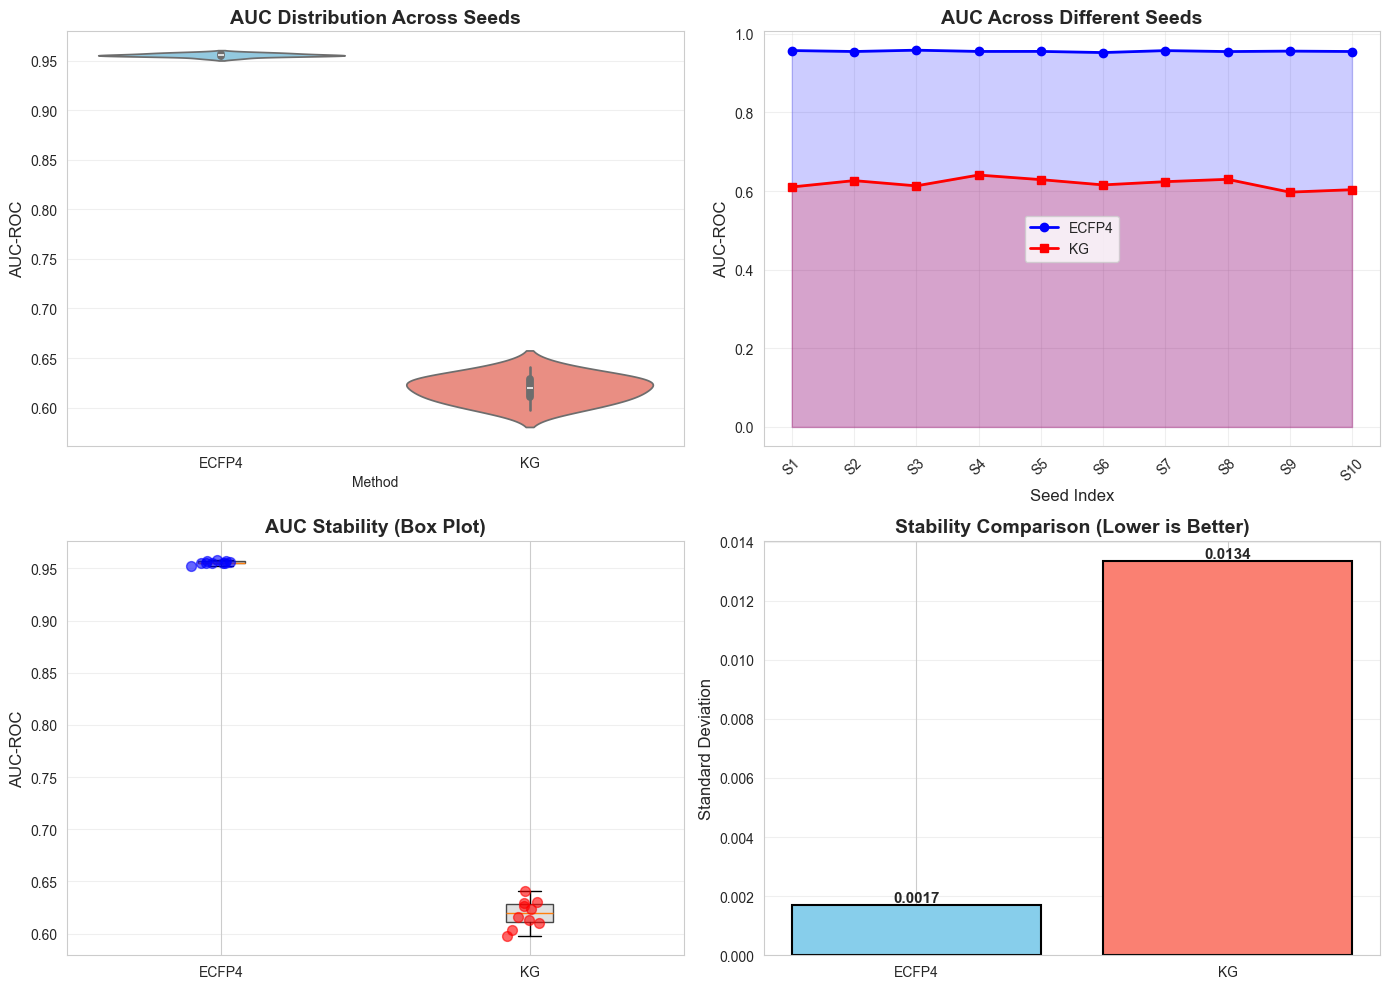


💾 Plot saved as 'stability_analysis_corrected.png'


In [8]:
# =============================================================================
# 8. VISUALIZATION (NO CHANGES)
# =============================================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# --- Plot 1: AUC Distribution (Violin Plot) ---
ax1 = axes[0, 0]
data_plot = pd.melt(results_df[['auc_ecfp', 'auc_kg']], 
                     var_name='Method', value_name='AUC')
data_plot['Method'] = data_plot['Method'].map({'auc_ecfp': 'ECFP4', 'auc_kg': 'KG'})
sns.violinplot(data=data_plot, x='Method', y='AUC', ax=ax1, palette=['skyblue', 'salmon'])
ax1.set_title('AUC Distribution Across Seeds', fontsize=14, fontweight='bold')
ax1.set_ylabel('AUC-ROC', fontsize=12)
ax1.grid(axis='y', alpha=0.3)

# --- Plot 2: Seed-by-Seed Comparison ---
ax2 = axes[0, 1]
x = np.arange(len(results_df))
ax2.plot(x, results_df['auc_ecfp'], marker='o', label='ECFP4', color='blue', linewidth=2)
ax2.plot(x, results_df['auc_kg'], marker='s', label='KG', color='red', linewidth=2)
ax2.fill_between(x, results_df['auc_ecfp'], alpha=0.2, color='blue')
ax2.fill_between(x, results_df['auc_kg'], alpha=0.2, color='red')
ax2.set_xticks(x)
ax2.set_xticklabels([f"S{i+1}" for i in range(len(results_df))], rotation=45)
ax2.set_xlabel('Seed Index', fontsize=12)
ax2.set_ylabel('AUC-ROC', fontsize=12)
ax2.set_title('AUC Across Different Seeds', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(alpha=0.3)

# --- Plot 3: Box Plot with Individual Points ---
ax3 = axes[1, 0]
bp = ax3.boxplot([results_df['auc_ecfp'], results_df['auc_kg']], 
                   labels=['ECFP4', 'KG'], patch_artist=True,
                   boxprops=dict(facecolor='lightgray', alpha=0.7))
for i, (method, color) in enumerate([('auc_ecfp', 'blue'), ('auc_kg', 'red')], 1):
    y = results_df[method]
    x = np.random.normal(i, 0.04, size=len(y))
    ax3.scatter(x, y, alpha=0.6, color=color, s=50, zorder=3)
ax3.set_ylabel('AUC-ROC', fontsize=12)
ax3.set_title('AUC Stability (Box Plot)', fontsize=14, fontweight='bold')
ax3.grid(axis='y', alpha=0.3)

# --- Plot 4: Standard Deviation Comparison ---
ax4 = axes[1, 1]
methods = ['ECFP4', 'KG']
stds = [results_df['auc_ecfp'].std(), results_df['auc_kg'].std()]
colors = ['skyblue', 'salmon']
bars = ax4.bar(methods, stds, color=colors, edgecolor='black', linewidth=1.5)
ax4.set_ylabel('Standard Deviation', fontsize=12)
ax4.set_title('Stability Comparison (Lower is Better)', fontsize=14, fontweight='bold')
ax4.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, std in zip(bars, stds):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
             f'{std:.4f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('stability_analysis_corrected.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n💾 Plot saved as 'stability_analysis_corrected.png'")

In [9]:
# =============================================================================
# 9. SAVE RESULTS
# =============================================================================

results_df.to_csv('multi_seed_results_corrected.csv', index=False)
print("\n💾 Results saved to 'multi_seed_results_corrected.csv'")

# Display full results table
print("\n" + "="*80)
print("📋 DETAILED RESULTS")
print("="*80)
display(results_df)


💾 Results saved to 'multi_seed_results_corrected.csv'

📋 DETAILED RESULTS


,seed,auc_ecfp,auc_kg,acc_ecfp,acc_kg,auc_kg_permuted,auc_random
0,42,0.957493,0.610414,0.880789,0.577187,0.535251,0.493969
1,123,0.955003,0.626613,0.880789,0.588336,0.495907,0.503907
2,456,0.958416,0.613296,0.881647,0.571184,0.495433,0.497396
3,789,0.955199,0.640806,0.878216,0.596055,0.510658,0.508864
4,101112,0.955300,0.629153,0.869640,0.595197,0.485822,0.515662
5,131415,0.952353,0.615727,0.868782,0.566895,0.469955,0.483531
6,161718,0.957319,0.623911,0.879931,0.584906,0.510181,0.526462
7,192021,0.954873,0.629933,0.869640,0.578045,0.485382,0.531483
8,222324,0.956035,0.597325,0.876501,0.555746,0.477412,0.503180
9,252627,0.955035,0.603529,0.881647,0.566038,0.488837,0.507595
